<a href="https://colab.research.google.com/github/chitra-psg/telecom_churn/blob/main/telecom_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn Prediction

**Author:** Chitra Govindasamy

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [250]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os
from datetime import datetime as dt

#sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler ,OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score ,confusion_matrix, precision_score, recall_score ,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV ,RepeatedStratifiedKFold ,cross_val_score ,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [251]:
#2 decimal places
pd.options.display.float_format = '{:.2f}'.format
# The dataset has many columns and the list is getting truncated in the output. Hence, adjusting the configuration
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('mode.use_inf_as_na', True)
#chart style
sns.set_style('darkgrid')

In [252]:
## Common Function to plot the countplot
def PlotAttribute(df_data, attribute, title, xlabel, ylabel, hueattribute = None, order = None):  
  if ( hueattribute ):
    chrt = sns.countplot(x=attribute,hue=hueattribute, data=df_data, order=order)
  else:
    chrt = sns.countplot(x=attribute,data=df_data)
  chrt.set_title(title,fontsize=14)
  chrt.set_xlabel(xlabel,fontsize=14)
  chrt.set_ylabel(ylabel,fontsize=14) 

  # To show count of values above bars
  for patch in chrt.patches:
      x, y = patch.get_xy()   # Bottom-left corner. 
      x += patch.get_width()/2 # Middle of the width.
      y += patch.get_height()  # Top of the bar
      color = patch.get_facecolor()
      chrt.text(x, y, str(y))
  return chrt

In [253]:
# Handle outlier using k-sigmoid method (Reference : starter notebook)
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [254]:
# Common Function to process data
def Preprocess(df_data, action):  
  if ( action == 'DropUniqueColumns' ):
    df_data.drop(['id'], axis=1, inplace=True)
  elif(action == 'Drop0VariationColumns'):
    df_data.drop(['circle_id',
                  'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',\
                  'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
                  'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'], axis=1, inplace=True)
    #               'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',\
  elif(action == 'DeriveLastRechargeDay'):
    CURRENT_DAY = (dt.strptime('2014/9/01', "%Y/%m/%d")) #assuming we are in the begining of Sep trying to predict churn so that necessary actions can be taken to prevent churn
    df_data['lastrechargedayago'] = abs(((df_data[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max(axis=1) ) - CURRENT_DAY).dt.days)
    df_data.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], axis = 1, inplace = True)
    df_data['lastdatarechargedayago'] = abs(((df_data[['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']].max(axis=1) ) - CURRENT_DAY).dt.days)
    df_data.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], axis = 1, inplace = True)
  elif(action == 'Fill0inFloatColumns'):
    for col in data.select_dtypes(include="float64").columns:
        df_data[col].fillna(0, inplace=True)
  elif(action == 'ConverttoDate'):
      # Convert date columns to date format
      for col in data.select_dtypes(include="object").columns:
          df_data[col] =  pd.to_datetime(df_data[col], format='%m/%d/%Y')
  elif(action == 'HandleOutlier'):
      df_data = df_data.apply(cap_outliers, axis=0)
  elif(action == 'DeriveAdditionalFeatures'):  
    df_data['vol_mb_6'] =  df_data['vol_2g_mb_6']  + df_data['vol_3g_mb_6'] 
    df_data['vol_mb_7'] =  df_data['vol_2g_mb_7']  + df_data['vol_3g_mb_7']  
    df_data['vol_mb_8'] =  df_data['vol_2g_mb_8']  + df_data['vol_3g_mb_8']  
    df_data['vol_mb_67'] =  (df_data[['vol_mb_6', 'vol_mb_7']].max(axis=1) )
    df_data['datavolusagegrowth'] =  -1 
    # round( (df_data['vol_mb_8']  /  df_data['vol_mb_8']  ), 1)
    df_data['datavolusagegrowth'].loc[df_data['vol_mb_67'] == 0]  =  round( (df_data['vol_mb_8']  /  df_data['vol_mb_8']  ), 1)
    df_data['datavolusagegrowth'].loc[df_data['vol_mb_67'] != 0]  = round( (df_data['vol_mb_8']  /  df_data['vol_mb_67']  ), 1)
    df_data.drop(['vol_2g_mb_6', 'vol_3g_mb_6', 'vol_2g_mb_7', 'vol_3g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_8', 'vol_mb_6', 'vol_mb_7','vol_mb_8','vol_mb_67'], axis = 1, inplace = True)
  elif(action == 'DropRedundantColumns'):  
    # loc_og_mou_* = loc_og_t2t_mou_*  + loc_og_t2m_mou_*   + loc_og_t2f_mou_* 	     + loc_og_t2c_mou_*
    df_data.drop(['loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6',
                  'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7',
                  'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8'], axis = 1, inplace = True)
     # std_og_mou_* = std_og_t2t_mou_*  + std_og_t2m_mou_*   + std_og_t2f_mou_* 	     + std_og_t2c_mou_*
    df_data.drop(['std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_t2c_mou_6',
                  'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_t2c_mou_7',
                  'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_t2c_mou_8'], axis = 1, inplace = True)
    # loc_ic_mou_* = loc_ic_t2t_mou_*  + loc_ic_t2m_mou_*   + loc_ic_t2f_mou_* 	     + loc_ic_t2c_mou_*
    df_data.drop(['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6',
                  'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7',
                  'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8'], axis = 1, inplace = True)
     # std_ic_mou_* = std_ic_t2t_mou_*  + std_ic_t2m_mou_*   + std_ic_t2f_mou_* 	     + std_ic_t2c_mou_*
    df_data.drop(['std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6',
                  'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7',
                  'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8'], axis = 1, inplace = True)
  return df_data

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [255]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
#sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
#print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(36, 2)


# Data Preparation

In [256]:
data.head().T

,0,1,2,3,4
id,0,1,2,3,4
circle_id,109,109,109,109,109
loc_og_t2o_mou,0.00,0.00,0.00,0.00,0.00
std_og_t2o_mou,0.00,0.00,0.00,0.00,0.00
loc_ic_t2o_mou,0.00,0.00,0.00,0.00,0.00
last_date_of_month_6,6/30/2014,6/30/2014,6/30/2014,6/30/2014,6/30/2014
last_date_of_month_7,7/31/2014,7/31/2014,7/31/2014,7/31/2014,7/31/2014
last_date_of_month_8,8/31/2014,8/31/2014,8/31/2014,8/31/2014,8/31/2014
arpu_6,31.28,0.00,60.81,156.36,240.71
arpu_7,87.01,122.79,103.18,205.26,128.19


Let's look at each variable's datatype:

In [257]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

Note: Most of the fields are numeric and few date fields are object type which needs to be converted to date

In [258]:
data.describe(include="all")

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.00,69999.00,69297.00,69297.00,69297.00,69999,69600,69266,69999.00,69999.00,69999.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,69999.00,69999.00,69999.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,69999.00,69999.00,69999.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,67231.00,67312.00,66296.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,68898,68765,67538,69999.00,69999.00,69999.00,17568,17865,18417,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,17568.00,17865.00,18417.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,69999.00,6

Note: 
1. There are fields like ID, circle ID which may not requried for further analysis. as ID is unique row ID and circle ID has zero variation. 
2. There are outliers in the data
3. There are few fields like night_pack, fb_user which have 0 or 1 (and null) which implies is a categorical field.

In [259]:
# Get the unique count
for col in data.columns:
    print("No of rows in " + col + ": ", len(data[col].unique()))

No of rows in id:  69999
No of rows in circle_id:  1
No of rows in loc_og_t2o_mou:  2
No of rows in std_og_t2o_mou:  2
No of rows in loc_ic_t2o_mou:  2
No of rows in last_date_of_month_6:  1
No of rows in last_date_of_month_7:  2
No of rows in last_date_of_month_8:  2
No of rows in arpu_6:  61615
No of rows in arpu_7:  61425
No of rows in arpu_8:  60194
No of rows in onnet_mou_6:  20058
No of rows in onnet_mou_7:  20077
No of rows in onnet_mou_8:  19726
No of rows in offnet_mou_6:  26255
No of rows in offnet_mou_7:  26140
No of rows in offnet_mou_8:  25996
No of rows in roam_ic_mou_6:  5307
No of rows in roam_ic_mou_7:  4241
No of rows in roam_ic_mou_8:  4253
No of rows in roam_og_mou_6:  6569
No of rows in roam_og_mou_7:  5306
No of rows in roam_og_mou_8:  5216
No of rows in loc_og_t2t_mou_6:  11492
No of rows in loc_og_t2t_mou_7:  11360
No of rows in loc_og_t2t_mou_8:  11297
No of rows in loc_og_t2m_mou_6:  17849
No of rows in loc_og_t2m_mou_7:  17642
No of rows in loc_og_t2m_mou_8: 

We can observe from the above result that, the following fields have few values which may not be useful for analysis

id 

=> ***Unique value ***

circle_id ; last_date_of_month_6; last_date_of_month_7; last_date_of_month_8 

=> ***same values across all rows***; 

loc_og_t2o_mou; std_og_t2o_mou; loc_ic_t2o_mou
std_og_t2c_mou_6; std_og_t2c_mou_7; std_og_t2c_mou_8
std_ic_t2o_mou_6; std_ic_t2o_mou_7; std_ic_t2o_mou_8 

=>*** Only 0 or NULL value in these columns***


In [260]:
distinct_value = data.nunique()
distinct_value

id                          69999
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
arpu_6                      61615
arpu_7                      61425
arpu_8                      60194
onnet_mou_6                 20057
onnet_mou_7                 20076
onnet_mou_8                 19725
offnet_mou_6                26254
offnet_mou_7                26139
offnet_mou_8                25995
roam_ic_mou_6                5306
roam_ic_mou_7                4240
roam_ic_mou_8                4252
roam_og_mou_6                6568
roam_og_mou_7                5305
roam_og_mou_8                5215
loc_og_t2t_mou_6            11491
loc_og_t2t_mou_7            11359
loc_og_t2t_mou_8            11296
loc_og_t2m_mou_6            17848
loc_og_t2m_mou_7            17641
loc_og_t2m_mou_8            17616
loc_og_t2f_mou

Check % of NULLs in each column

In [261]:
(data.isnull().sum()/ len(data)) * 100

id                          0.00
circle_id                   0.00
loc_og_t2o_mou              1.00
std_og_t2o_mou              1.00
loc_ic_t2o_mou              1.00
last_date_of_month_6        0.00
last_date_of_month_7        0.57
last_date_of_month_8        1.05
arpu_6                      0.00
arpu_7                      0.00
arpu_8                      0.00
onnet_mou_6                 3.95
onnet_mou_7                 3.84
onnet_mou_8                 5.29
offnet_mou_6                3.95
offnet_mou_7                3.84
offnet_mou_8                5.29
roam_ic_mou_6               3.95
roam_ic_mou_7               3.84
roam_ic_mou_8               5.29
roam_og_mou_6               3.95
roam_og_mou_7               3.84
roam_og_mou_8               5.29
loc_og_t2t_mou_6            3.95
loc_og_t2t_mou_7            3.84
loc_og_t2t_mou_8            5.29
loc_og_t2m_mou_6            3.95
loc_og_t2m_mou_7            3.84
loc_og_t2m_mou_8            5.29
loc_og_t2f_mou_6            3.95
loc_og_t2f

Few columns have more than 70% missing values. The missing values % for month 6,7,8 across various fields here and it looks like the customers didnt recharge that particualr month and hence the metrics related to that month is also null. 

The list columns can be grouped as arpu, mou, ic, og, rech, 3g mb, 2g mb, service flag fields like - night pack, monthly 2g,3g, sachet, fb service. In places where there is null it means the facility was not used e.g. mou null indicate no call was made so these can be filled with 0. Flag fields like fb service being null indicate that the service wasnt used and that be 0 as well.

As per the problem statement is focussed on high value customers churn probability. A customer whose recharge amount is at higher end ( e.g. more than average recharge amount) will be considered high value customers. So, lets keep the rech related columns for now and impute missing values. 

In [262]:
outlier = data.describe().T.round(2)
outlier['flag'] =  (outlier['75%'] != 0) | (((outlier['max'] - outlier['75%']) / (outlier['75%'] - outlier['50%'])) > 50)
outlier

,count,mean,std,min,25%,50%,75%,max,flag
id,69999.00,34999.00,20207.12,0.00,17499.50,34999.00,52498.50,69998.00,True
circle_id,69999.00,109.00,0.00,109.00,109.00,109.00,109.00,109.00,True
loc_og_t2o_mou,69297.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
std_og_t2o_mou,69297.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
loc_ic_t2o_mou,69297.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,False
arpu_6,69999.00,283.13,334.21,-2258.71,93.58,197.48,370.79,27731.09,True
arpu_7,69999.00,278.19,344.37,-1289.71,86.71,191.59,365.37,35145.83,True
arpu_8,69999.00,278.86,351.92,-945.81,84.10,192.23,369.91,33543.62,True
onnet_mou_6,67231.00,133.15,299.96,0.00,7.41,34.11,119.39,7376.71,True
onnet_mou_7,67312.00,133.89,311.28,0.00,6.68,32.28,115.84,8157.78,True


###Note : Most of the attributes have outlier in it. We could treat the outliers by removing the records are handle them via. scaling technique (Robust Scaler)

#Preprocessing

In [263]:
data = Preprocess(data,'DropUniqueColumns')
data = Preprocess(data,'Drop0VariationColumns')
data = Preprocess(data,'ConverttoDate')
data = Preprocess(data,'DeriveLastRechargeDay')
data = Preprocess(data,'Fill0inFloatColumns')
data = Preprocess(data,'DeriveAdditionalFeatures')
data = Preprocess(data,'DropRedundantColumns')

In [264]:
(data.isnull().sum()/ len(data)) * 100

arpu_6                    0.00
arpu_7                    0.00
arpu_8                    0.00
onnet_mou_6               0.00
onnet_mou_7               0.00
onnet_mou_8               0.00
offnet_mou_6              0.00
offnet_mou_7              0.00
offnet_mou_8              0.00
roam_ic_mou_6             0.00
roam_ic_mou_7             0.00
roam_ic_mou_8             0.00
roam_og_mou_6             0.00
roam_og_mou_7             0.00
roam_og_mou_8             0.00
loc_og_mou_6              0.00
loc_og_mou_7              0.00
loc_og_mou_8              0.00
std_og_mou_6              0.00
std_og_mou_7              0.00
std_og_mou_8              0.00
isd_og_mou_6              0.00
isd_og_mou_7              0.00
isd_og_mou_8              0.00
spl_og_mou_6              0.00
spl_og_mou_7              0.00
spl_og_mou_8              0.00
og_others_6               0.00
og_others_7               0.00
og_others_8               0.00
total_og_mou_6            0.00
total_og_mou_7            0.00
total_og

#Filter for High Value Customer

Identify High Value Customer based on arpu - Average revenue per user measures the amount of money that a company can expect to generate from an individual customer. June /Julyis expected to be in good phase where arpu is assumed to be good. We will use June/July arpu to filter customers. Each month, 50% of revenue is generated by 20% customers whose arpu is above 80th percentile. We will use this logic to filter high value customers

In [265]:
df6 = data.loc[(data['arpu_6'] >= data['arpu_6'].quantile(0.8))]
df7 = data.loc[(data['arpu_7'] >= data['arpu_7'].quantile(0.8))]

data_key_customers = pd.concat([df6,df7]).drop_duplicates().reset_index(drop=True)
print('% of revenue generated by the filtered customers for June = ', df6['arpu_6'].sum()/data['arpu_6'].sum() )
print('% of revenue generated by the filtered customers for July = ', df7['arpu_7'].sum()/data['arpu_7'].sum() )


% of revenue generated by the filtered customers for June =  0.5249726111888899
% of revenue generated by the filtered customers for July =  0.5317645851838823


In [266]:
data_key_customers.shape

(18792, 110)

## EDA

In [267]:
## Common Function to plot the countplot
def PlotAttribute(df_data, attribute, title, xlabel, ylabel, hueattribute = None, order = None):  
  if ( hueattribute ):
    chrt = sns.countplot(x=attribute,hue=hueattribute, data=df_data, order=order)
  else:
    chrt = sns.countplot(x=attribute,data=df_data)
  chrt.set_title(title,fontsize=14)
  chrt.set_xlabel(xlabel,fontsize=14)
  chrt.set_ylabel(ylabel,fontsize=14) 

  # To show count of values above bars
  for patch in chrt.patches:
      x, y = patch.get_xy()   # Bottom-left corner. 
      x += patch.get_width()/2 # Middle of the width.
      y += patch.get_height()  # Top of the bar
      color = patch.get_facecolor()
      chrt.text(x, y, str(y))
  return chrt

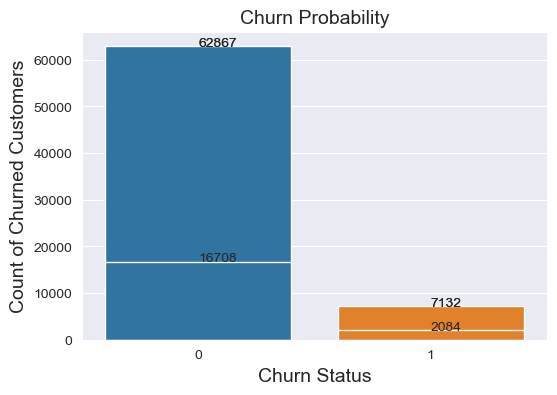

In [268]:
#Analysis on Churn Probability
plt.figure(figsize= (6,4))
PlotAttribute(data, 'churn_probability', 'Churn Probability', 'Churn Status', 'Count of Churned Customers')
PlotAttribute(data_key_customers, 'churn_probability', 'Churn Probability', 'Churn Status', 'Count of Churned Customers')
plt.show()



Note: 

Overall, 10% customers have churned.

Among the total high value customers, 12 % customers have churned.

Approx. Among total customers who have churned, 30% customers are high value customers

### Last Recharge Date

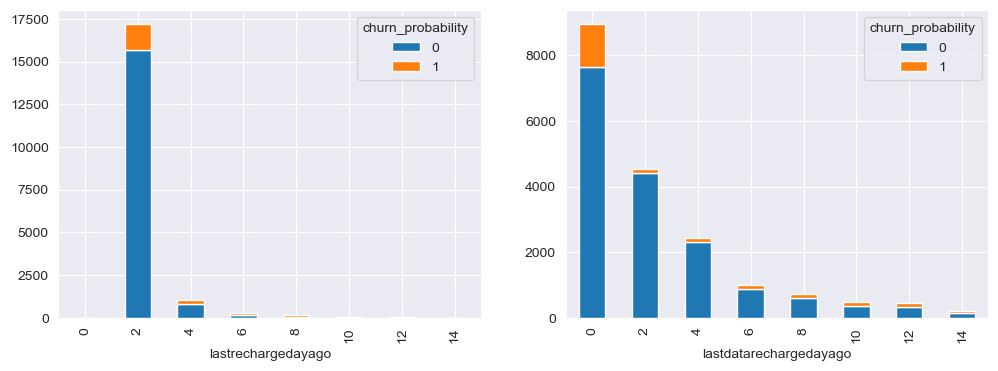

In [269]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
# bin the aon column with yearwise segments and plot the counts for each segments
bins = [-1, 0, 2, 4, 6,8, 10, 12, 14]
labels = [0, 2, 4, 6,8, 10, 12, 14]
pd.crosstab(pd.cut(round((data_key_customers['lastrechargedayago']/7),1), bins = bins, labels = labels ), data_key_customers['churn_probability']).plot(kind='bar', stacked=True,  ax = ax1)
pd.crosstab(pd.cut(round((data_key_customers['lastdatarechargedayago']/7),1), bins = bins, labels = labels ), data_key_customers['churn_probability']).plot(kind='bar', stacked=True,  ax = ax2)
plt.show()

Note : 

Even customers who have recharged in the last 2 weeks have churned.

Last Data Recharge being 0 indicates the date is not available. We can see customers who havent recharged data in the recent past/unknown have churned

#Age on Network

<Figure size 600x400 with 0 Axes>

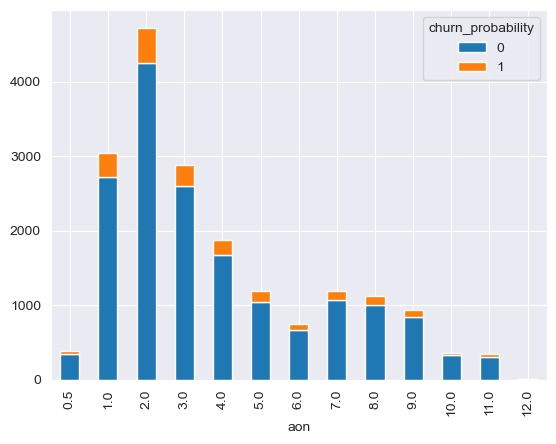

In [270]:
plt.figure(figsize= (6,4))
# bin the aon column with yearwise segments and plot the counts for each segments
bins = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#sns.countplot(pd.cut(round(((data['aon']/30)/12),1), bins = bins, labels = labels ), ax =ax1)
pd.crosstab(pd.cut(round(((data_key_customers['aon']/30)/12),1), bins = bins, labels = labels ), data['churn_probability']).plot(kind='bar', stacked=True)
plt.show()
#Churn probability is higher when aon is between 1 and 3 years.

#Average revenue per user

<AxesSubplot:xlabel='arpu_8_range'>

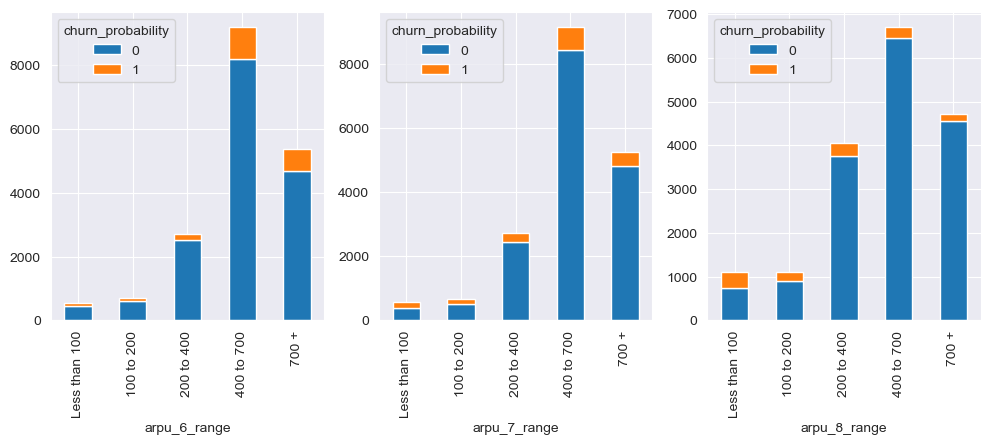

In [271]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 4))
arpu_bins = [0, 100,200,400,700,15000]
arpu_bucket = ['Less than 100', '100 to 200', '200 to 400', '400 to 700', '700 +']
data_key_customers['arpu_6_range'] = pd.cut(data_key_customers['arpu_6'].astype(int), arpu_bins, labels=arpu_bucket)
data_key_customers['arpu_7_range'] = pd.cut(data_key_customers['arpu_7'].astype(int), arpu_bins, labels=arpu_bucket)
data_key_customers['arpu_8_range'] = pd.cut(data_key_customers['arpu_8'].astype(int), arpu_bins, labels=arpu_bucket)
#print(data['arpu_6_range'].value_counts(), "\n" ,
#data['arpu_7_range'].value_counts() , "\n",
#data['arpu_8_range'].value_counts())
pd.crosstab( data_key_customers['arpu_6_range'], data_key_customers['churn_probability']).plot(kind='bar', stacked=True, ax = ax1)

pd.crosstab( data_key_customers['arpu_7_range'], data_key_customers['churn_probability']).plot(kind='bar', stacked=True, ax = ax2)

pd.crosstab( data_key_customers['arpu_8_range'], data_key_customers['churn_probability']).plot(kind='bar', stacked=True, ax = ax3)

# It can be noticed that arpu reduces over the period when the customer is about to churn

In [272]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={'arpu_6':np.sum,'arpu_7':np.sum,'arpu_8':np.sum,
                                                                   'arpu_3g_6':np.sum,'arpu_3g_7':np.sum,'arpu_3g_8':np.sum,
                                                                   'arpu_2g_6':np.sum,'arpu_2g_7':np.sum,'arpu_2g_8':np.sum}))).round(2)
table

,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_6,arpu_7,arpu_8
churn_probability,,,,,,,,,
0,"930,783.16","988,717.56","920,991.64","1,011,660.82","1,071,999.28","1,010,151.37","10,238,657.72","10,502,555.31","9,851,675.15"
1,"89,226.4","68,282.36","24,275.48","97,769.48","68,903.93","25,369.78","1,372,525.36","1,008,051.32","433,936.29"


Note : In cases of churn, we can notice arpu declining over the period. Arpu is a good indicator to identify customer who might churn soon.

### Categorical Fields - Service packs 

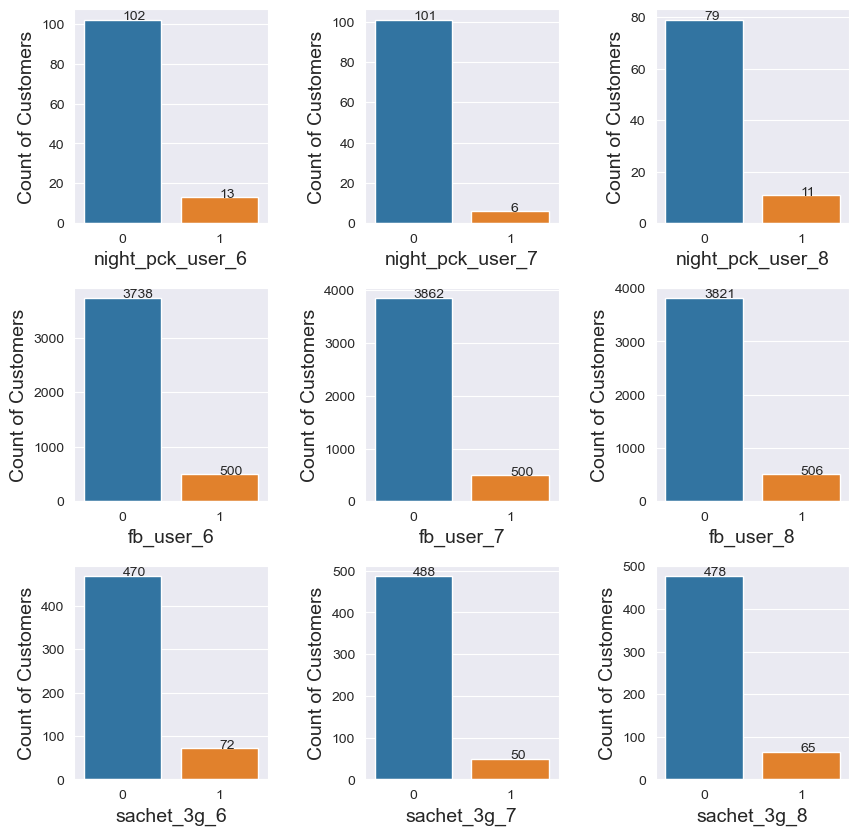

In [273]:
#Analysis on categorrical fields
category_list = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']
counter = 1

plt.figure(figsize = (10, 10))

for col_list in category_list:
    plt.subplot(3, 3, counter)
    service_data = data_key_customers.loc[(data[col_list] == 1)]
    PlotAttribute(service_data, 'churn_probability', '', col_list, 'Count of Customers')
    counter += 1

plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.5)
plt.show()

Note : There doesnt seem to be much variation in night pack /3g sachet but there is slight reduction in Facebook service usage among churn customers

In [274]:
pd.options.display.float_format = '{:,}'.format
table = ((pd.pivot_table(data_key_customers,index=['churn_probability'],aggfunc={'total_og_mou_6':np.sum,'total_og_mou_7':np.sum,'total_og_mou_8':np.sum,
                                                                   'total_ic_mou_6':np.sum,'total_ic_mou_7':np.sum,'total_ic_mou_8':np.sum,
                                                                   'av_rech_amt_data_6':np.sum,'av_rech_amt_data_7':np.sum,'av_rech_amt_data_8':np.sum}))).round(2)
table

,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn_probability,,,,,,,,,
0,"1,635,437.89","1,792,896.64","1,667,146.31","5,220,803.68","5,452,243.98","5,299,921.48","11,886,647.38","12,650,548.15","11,755,970.96"
1,"135,116.0","109,712.58","40,395.33","476,655.5","335,039.46","117,299.0","1,720,832.85","1,235,183.23","421,028.34"


Note : Outgoing calls, Incoming Calls and recharge amount for data seems to be declining for during the action phase in cases of customer churning

<Figure size 600x400 with 0 Axes>

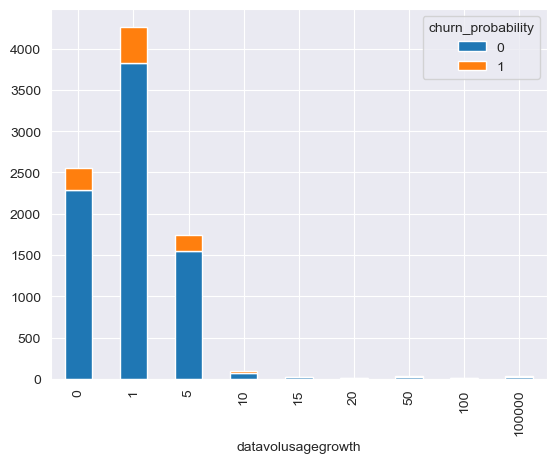

In [275]:
plt.figure(figsize= (6,4))
# bin the aon column with yearwise segments and plot the counts for each segments
bins = [-10, -1, 0, 1, 5, 10, 15, 20, 50, 100, 100000]
labels = [ -1, 0, 1, 5, 10, 15, 20, 50, 100, 100000]
pd.crosstab(pd.cut(round(data_key_customers['datavolusagegrowth'],1), bins = bins, labels = labels ), data['churn_probability']).plot(kind='bar', stacked=True)
plt.show()
#Churn probability is higher when aon is between 1 and 3 years.

In [319]:
data_key_customers['datavolusagegrowth'].value_counts()

0.0         12582
1.0          1092
0.7           498
0.8           459
0.6           436
0.9           431
0.5           405
0.4           309
1.1           294
0.3           266
1.2           239
0.2           213
1.3           190
0.1           156
1.4           155
1.5           118
1.6            98
1.7            92
1.9            62
1.8            62
2.0            48
2.4            40
2.1            34
2.2            30
2.3            28
2.5            27
2.8            19
2.9            19
3.0            19
2.6            17
3.1            16
2.7            15
3.3            12
3.7            10
3.2            10
3.9             9
4.2             8
4.1             8
4.4             8
3.5             7
4.3             7
4.9             7
3.8             7
3.4             6
3.6             6
5.4             6
8.1             5
6.0             5
7.7             5
5.5             4
5.1             4
7.9             4
4.0             4
6.4             4
6.9             4
5.2       

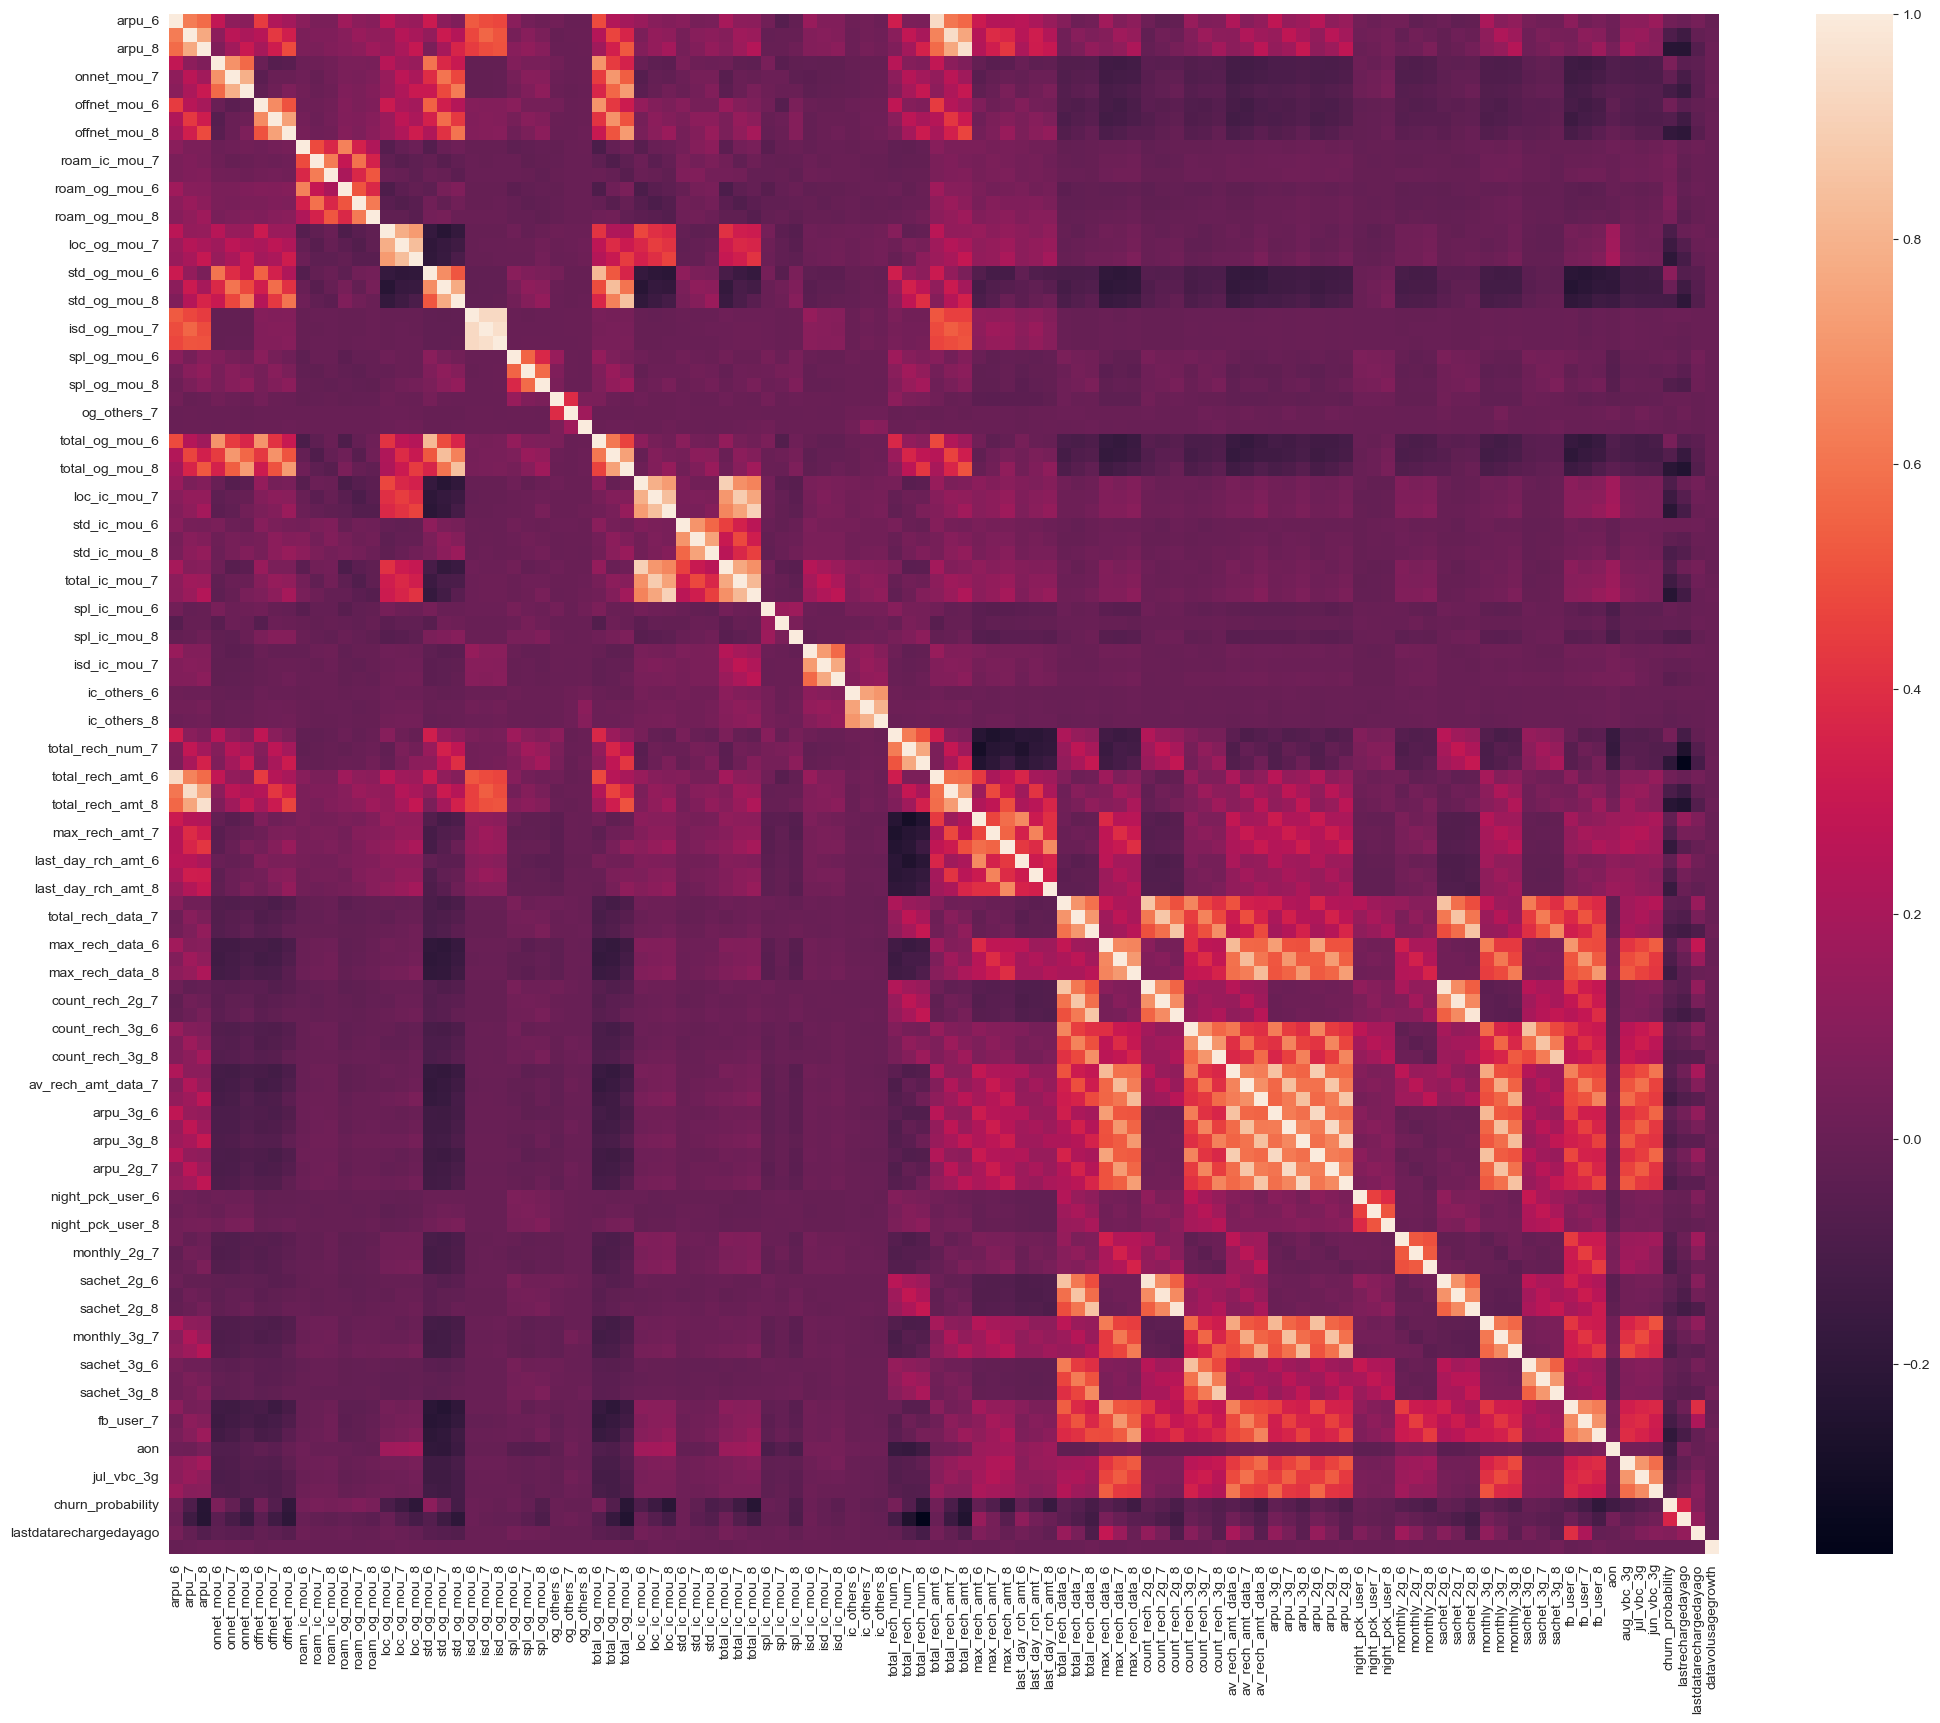

In [279]:
plt.figure(figsize = (25, 20))

sns.heatmap(data_key_customers.corr())

plt.show()

In [280]:
corr_matrix = data_key_customers.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
upper_triangle = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)))

highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]
print("List of highly correlated features from the above plot - \n\n", highly_correlated_features)
print("\n\nTotal features with high correlation - ", len(highly_correlated_features))

List of highly correlated features from the above plot - 

 ['loc_og_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


Total features with high correlation -  34


Note: On inspecting the data, we can see that are relationships betweens many columns. Few are  -


loc_og_mou_* = loc_og_t2t_mou_*
	     + loc_og_t2m_mou_*
	     + loc_og_t2f_mou_*
	     + loc_og_t2c_mou_*

std_og_mou_* = std_og_t2t_mou_*
	     + std_og_t2m_mou_*
	     + std_og_t2f_mou_*
	     + std_og_t2c_mou_*

total_og_mou_* = loc_og_mou_*
	      + std_og_mou_*
	      + isd_og_mou_*
	      + spl_og_mou_*
	      + X

loc_ic_mou_* = loc_ic_t2t_mou_*
	     + loc_ic_t2m_mou_*
	     + loc_ic_t2f_mou_*

std_ic_mou_* = std_ic_t2t_mou_*
	     + std_ic_t2m_mou_*
	     + std_ic_t2f_mou_*
	     + std_ic_t2o_mou_*

total_ic_mou_* = loc_ic_mou_*
	     + std_ic_mou_*
	     + spl_ic_mou_*
	     + isd_ic_mou_*
	     + Y

arpu_3g_* ,  arpu_2g_* and arpu are correlated. 
total_rech_amt_*, max_rech_amt_*, last_day_rch_amt_* and av_rech_amt_data_* are correlated.


The highly correlated attributes can be dropped but we will be using PCA to reduce dimension and it will be handled as part of it.

We can derive a consolidated attribute and remove the multiple correlated columns









# 2. Create X, y and then Train test split


In [296]:
telecom_df = data_key_customers.copy()
y = telecom_df.pop('churn_probability')
X = telecom_df

X.shape , y.shape

((18792, 112), (18792,))

Splitting train and test data to avoid any contamination of the test data

In [297]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state = 42, stratify = y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13154, 112), (5638, 112), (13154,), (5638,))

In [298]:
X_train.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,lastrechargedayago,lastdatarechargedayago,datavolusagegrowth,arpu_6_range,arpu_7_range,arpu_8_range
7569,615.478,539.103,453.578,79.84,109.69,110.83,429.29,509.91,502.46,249.54,0.0,0.0,172.29,0.0,0.0,163.24,413.43,423.49,172.98,206.18,166.16,0.0,0.0,0.0,0.61,0.28,23.63,0.0,0.0,0.0,336.84,619.89,613.29,94.93,126.56,180.01,225.69,17.09,37.03,320.63,143.66,217.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,20,14,732,631,545,120,67,67,30,44,42,3.0,2.0,1.0,25.0,25.0,23.0,3.0,2.0,1.0,0.0,0.0,0.0,75.0,50.0,23.0,0.0,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0,0,0,3,2,1,0,0,0,0,0,0,1.0,1.0,0.0,887,0.0,55.58,0.0,2.0,17.0,0.0,400 to 700,400 to 700,400 to 700
8373,571.704,485.775,792.101,214.78,144.56,93.79,388.73,355.69,658.44,0.0,0.0,0.0,0.0,0.0,0.0,585.49,458.46,729.79,12.76,38.78,15.71,0.0,0.0,0.0,5.24,3.01,6.73,0.0,0.0,0.0,603.51,500.26,752.24,327.99,300.44,769.33,1.23,1.43,1.01,329.38,302.71,770.34,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.83,0.0,12,15,21,636,570,940,80,110,100,50,10,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,364,0.0,0.0,0.0,2.0,0.0,0.0,400 to 700,400 to 700,700 +
4129,661.901,62.366,634.009,168.24,24.81,180.29,716.88,34.74,968.01,39.68,90.49,11.36,98.03,59.56,4.19,85.34,0.0,224.64,701.74,0.0,919.46,0.0,0.0,0.0,0.0,0.0,0.86,0.0,0.0,0.0,787.09,0.0,"1,144.98",85.26,0.0,77.96,14.51,0.0,47.88,104.89,0.0,133.09,0.0,0.0,0.0,5.11,0.0,7.24,0.0,0.0,0.0,10,6,7,677,76,706,110,50,130,50,0,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1132,0.0,0.0,0.0,6.0,0.0,0.0,400 to 700,Less than 100,400 to 700
5684,462.172,368.225,465.322,855.28,735.48,717.38,61.44,57.09,90.86,0.0,0.0,0.0,0.0,0.0,0.0,44.43,46.04,53.63,846.01,746.53,754.61,0.0,0.0,0.0,32.09,0.0,1.93,1.31,0.0,0.0,923.86,792.58,810.18,159.88,123.69,134.98,3.18,0.31,44.86,163.09,124.46,179.84,0.0,0.0,0.0,0.03,0.45,0.0,0.0,0.0,0.0,9,6,9,476,426,526,120,120,150,120,120,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1495,0.0,0.0,0.0,1.0,0.0,0.0,400 to 700,200 to 400,400 to 700
14571,302.192,474.836,"3,088.266",0.0,1.43,25.36,11.31,61.33,505.29,0.0,0.0,0.0,0.0,0.0,0.0,0.23,7.43,55.33,0.0,0.0,0.0,9.83,55.33,476.29,1.25,0.0,5.13,5.43,0.0,0.0,16.74,62.76,536.76,21.14,17.14,49.69,0.0,0.0,0.16,65.56,32.08,297.51,0.0,0.0,0.0,44.41,14.93,247.64,0.0,0.0,0.0,10,10,37,353,565,3652,154,110,239,27,20,130,1.0,0.0,1.0,154.0,0.0,17.0,1.0,0.0,1.

### Model Building

In [299]:
data_key_customers.info(verbose =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18792 entries, 0 to 18791
Data columns (total 113 columns):
 #    Column                  Dtype   
---   ------                  -----   
 0    arpu_6                  float64 
 1    arpu_7                  float64 
 2    arpu_8                  float64 
 3    onnet_mou_6             float64 
 4    onnet_mou_7             float64 
 5    onnet_mou_8             float64 
 6    offnet_mou_6            float64 
 7    offnet_mou_7            float64 
 8    offnet_mou_8            float64 
 9    roam_ic_mou_6           float64 
 10   roam_ic_mou_7           float64 
 11   roam_ic_mou_8           float64 
 12   roam_og_mou_6           float64 
 13   roam_og_mou_7           float64 
 14   roam_og_mou_8           float64 
 15   loc_og_mou_6            float64 
 16   loc_og_mou_7            float64 
 17   loc_og_mou_8            float64 
 18   std_og_mou_6            float64 
 19   std_og_mou_7            float64 
 20   std_og_mou_8            fl

In [300]:
categorical_features = [i for i in telecom_df.columns if re.search('range',i)]
numeric_features = [i for i in telecom_df.columns if not re.search('night|fb|range',i)]
categorical_features , numeric_features

(['arpu_6_range', 'arpu_7_range', 'arpu_8_range'],
 ['arpu_6',
  'arpu_7',
  'arpu_8',
  'onnet_mou_6',
  'onnet_mou_7',
  'onnet_mou_8',
  'offnet_mou_6',
  'offnet_mou_7',
  'offnet_mou_8',
  'roam_ic_mou_6',
  'roam_ic_mou_7',
  'roam_ic_mou_8',
  'roam_og_mou_6',
  'roam_og_mou_7',
  'roam_og_mou_8',
  'loc_og_mou_6',
  'loc_og_mou_7',
  'loc_og_mou_8',
  'std_og_mou_6',
  'std_og_mou_7',
  'std_og_mou_8',
  'isd_og_mou_6',
  'isd_og_mou_7',
  'isd_og_mou_8',
  'spl_og_mou_6',
  'spl_og_mou_7',
  'spl_og_mou_8',
  'og_others_6',
  'og_others_7',
  'og_others_8',
  'total_og_mou_6',
  'total_og_mou_7',
  'total_og_mou_8',
  'loc_ic_mou_6',
  'loc_ic_mou_7',
  'loc_ic_mou_8',
  'std_ic_mou_6',
  'std_ic_mou_7',
  'std_ic_mou_8',
  'total_ic_mou_6',
  'total_ic_mou_7',
  'total_ic_mou_8',
  'spl_ic_mou_6',
  'spl_ic_mou_7',
  'spl_ic_mou_8',
  'isd_ic_mou_6',
  'isd_ic_mou_7',
  'isd_ic_mou_8',
  'ic_others_6',
  'ic_others_7',
  'ic_others_8',
  'total_rech_num_6',
  'total_rech_num_

In [301]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(
    [
        ('numeric', numeric_transformer, numeric_features),
        ("categorical",categorical_transformer , categorical_features)
    ],
    remainder = 'drop'
)

In [302]:
pca = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('pca',PCA(random_state=42))
    ]
)
telecom_pca = pca.fit_transform(X_train)
pca = pca.named_steps['pca']
ser = pd.Series((pca.explained_variance_ratio_.cumsum()*100).round(2))
p90 = ser[ser>=90].index[0]
p95 = ser[ser>=95].index[0]
(p90 , p95)

(41, 54)

#### Insight
- 90% of variation is explained by 40 feature
- 95% of variation is explained by 54 feature

#### PCA and logistic Regression

In [303]:
# class imbalance
y_train.value_counts()/y_train.shape

0   0.8890831686179109
1   0.1109168313820891
Name: churn_probability, dtype: float64

#### As we can see there is class imbalance. IT can be resolved by
 - putting custom class weight 
 -  SMOTE method 


In [304]:
pca_log = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('pca',PCA()),
        ("logistic", LogisticRegression())
    ]
)

params = {
    'logistic__penalty': ['l1', 'l2'],
    'logistic__C': [0.001, 0.01],
    'logistic__random_state': [42],
    'logistic__class_weight':[{0:0.1, 1: 0.9}],
    'pca__n_components': [p90,p95],
    'pca__random_state':[42]
}

rskf = StratifiedKFold(n_splits = 4,shuffle=True, random_state = 42)

cv = GridSearchCV(estimator=pca_log, cv = rskf , param_grid=params, scoring='roc_auc', n_jobs=-1,verbose=True)

cv.fit(X_train, y_train)

print(f'Best Accuracy: {cv.best_score_:.3f}\n')
print(f'Best parameter set: {cv.best_params_}\n')

print(f'Train Confusion Matrix: \n {confusion_matrix(y_train, cv.predict(X_train))}\n')
print(f'Test Confusion Matrix:\n {confusion_matrix(y_test, cv.predict(X_test))}\n')

print(f'Train Recall:\n {recall_score(y_train, cv.predict(X_train))}\n')
print(f'Test Recall:\n {recall_score(y_test, cv.predict(X_test))}\n')


print(f'Train Scores: \n{classification_report(y_train, cv.predict(X_train))}\n')
print(f'Test Scores: \n{classification_report(y_test, cv.predict(X_test))}\n')


Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best Accuracy: 0.904

Best parameter set: {'logistic__C': 0.01, 'logistic__class_weight': {0: 0.1, 1: 0.9}, 'logistic__penalty': 'l2', 'logistic__random_state': 42, 'pca__n_components': 54, 'pca__random_state': 42}

Train Confusion Matrix: 
 [[9623 2072]
 [ 209 1250]]

Test Confusion Matrix:
 [[4127  886]
 [ 103  522]]

Train Recall:
 0.8567511994516792

Test Recall:
 0.8352

Train Scores: 
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     11695
           1       0.38      0.86      0.52      1459

    accuracy                           0.83     13154
   macro avg       0.68      0.84      0.71     13154
weighted avg       0.91      0.83      0.85     13154


Test Scores: 
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      5013
           1       0.37      0.84      0.51       625

    accuracy                           0

#### Random Forest  Model 

In [316]:
forest_pipe = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('forest',RandomForestClassifier(class_weight={0:0.1, 1: 0.9}))
    ]
)


In [318]:
# hyperparameter space
params = {"forest__criterion": ['gini'], "forest__max_samples": [0.3,0.4], "forest__n_estimators":[500,800], 
         "forest__min_samples_leaf": [100,200], "forest__max_leaf_nodes": [30,40], "forest__max_depth": [ 6,8]}

folds = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

model = GridSearchCV(estimator=forest_pipe, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)


model.fit(X_train, y_train)
print("\nBest AUC: ", model.best_score_)
print("\nBest hyperparameters: ", model.best_params_)

# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)



Fitting 4 folds for each of 32 candidates, totalling 128 fits

Best AUC:  0.9300730195840852

Best hyperparameters:  {'forest__criterion': 'gini', 'forest__max_depth': 8, 'forest__max_leaf_nodes': 30, 'forest__max_samples': 0.4, 'forest__min_samples_leaf': 100, 'forest__n_estimators': 500}
[[4486  527]
 [ 132  493]]


In [321]:
# check sensitivity and specificity
print(f'Train Scores: \n{classification_report(y_train, cv.predict(X_train))}\n')
print(f'Test Scores: \n{classification_report(y_test, cv.predict(X_test))}\n')

print(f'Test Confusion Matrix:\n {confusion_matrix(y_test, cv.predict(X_test))}\n')
print(f'Train Confusion Matrix:\n {confusion_matrix(y_train, cv.predict(X_train))}\n')



# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))


Train Scores: 
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     11695
           1       0.38      0.86      0.52      1459

    accuracy                           0.83     13154
   macro avg       0.68      0.84      0.71     13154
weighted avg       0.91      0.83      0.85     13154


Test Scores: 
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      5013
           1       0.37      0.84      0.51       625

    accuracy                           0.82      5638
   macro avg       0.67      0.83      0.70      5638
weighted avg       0.91      0.82      0.85      5638


Test Confusion Matrix:
 [[4127  886]
 [ 103  522]]

Train Confusion Matrix:
 [[9623 2072]
 [ 209 1250]]

AUC:    	 0.93


Previous RRun Details:


Best AUC:  0.9352170512211003

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 30, 'max_samples': 0.3, 'min_samples_leaf': 100, 'n_estimators': 500}

[[17489  1371]
 [  519  1621]]
 
 
 Train Scores: 
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     44007
           1       0.33      0.86      0.47      4992

    accuracy                           0.81     48999
   macro avg       0.65      0.83      0.68     48999
weighted avg       0.91      0.81      0.84     48999


Test Confusion Matrix:
 [[15124  3736]
 [  347  1793]]

AUC:    	 0.93

# BELOW CODE TO BE REPLACED

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

In [ ]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

In [ ]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

In [ ]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(16)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [ ]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

In [ ]:
lr.score(pca_components[:,:2], y_train)

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [ ]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [ ]:
pipe.fit(X_train[new_vars], y_train)

In [ ]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

In [ ]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [ ]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

In [ ]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [ ]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

In [ ]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [ ]:
sample.head()

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [ ]:
unseen.head()

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [ ]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output.to_csv('submission_pca_lr_13jul.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.